In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
%matplotlib inline

# Initialisation
## Données

La fonction suivante pose parfois des problèmes pour les données observées (trop de bruit ?)

In [2]:
with open('growthR_sim.npy', 'rb') as f:
    wt_sim = np.load(f)
    wt_sim = wt_sim[:,wt_sim[0,:]!=0]
with open('growthR_sim_noisy.npy', 'rb') as f:
    wt_sim_noise = np.load(f)
    wt_sim_noise = wt_sim_noise[:,wt_sim_noise[0,:]!=0]

```
def normalise(wt_init): # renvoie Wt/W0 pour que toutes les cellules partent du même taux de croissance
    wt=wt_init.copy()
    for i in range(len(wt[0,:])):
        if(wt[0,i]!=0):
            wt[:,i]=wt[:,i]/wt[0,i]
        else:
             wt[:,i]=wt[:,i]*0
    return wt

def normalise2(wt_init,n): # renvoie Wt/moyenne(W0:Wn) pour que toutes les cellules partent presque du même taux de croissance et que ce soit lisse !
    wt=wt_init.copy()
    for i in range(len(wt[0,:])):
        nm=np.mean(wt[0:n,i])
        if(nm!=0):
            wt[:,i]=wt[:,i]/nm
        else:
             wt[:,i]=0
    return wt
```

## Fonctions générales

In [3]:
def fourier_inverse0(X,Xi,F_Xi):  # ???
    return [np.mean(F_Xi*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def fourier_inverse(X,Xi,F_Xi):  # ???
    return [(Xi[1]-Xi[0])*np.sum(F_Xi*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def get_fourier_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*Wt[Wt>0])) for xi in Xi]

def get_fourier_log_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*np.log(Wt[Wt>0]))) for xi in Xi]

In [4]:
np.angle([1.0, 1.0j, 1+1j])

array([0.        , 1.57079633, 0.78539816])

In [5]:
np.imag([1.0, 1.0j, 1+1j])

array([0., 1., 1.])

In [6]:
np.abs([1.0, 1.0j, 1+1j])

array([1.        , 1.        , 1.41421356])

In [7]:
np.real([1.0, 1.0j, 1+1j])

array([1., 0., 1.])

In [22]:
def draw_log_log(wt,ximin,ximax,nbreaks_xi,tmax,n_renorm=0,titre=""):
    #tot=[]
    #tot_tmp=[]
    #xi=np.linspace(ximin,ximax,nbreaks_xi)
    #for t in range(tmax):
    #    #tot+=[np.log(np.abs(np.array(Fu_t))]
    #    Fu_t=get_fourier_log_wt(xi,wt[t])
    #    tot_tmp+=[np.array(Fu_t)]
    #tot_tmp=np.array(tot_tmp)
    #for i in range(len(tot_tmp[0,:])):
    #    tot_tmp[:,i]=tot_tmp[:,i]/tot_tmp[0,i]
    #tot=np.log(np.abs(tot_tmp))
    #tot=np.array(tot)
    
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot = np.abs([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    if n_renorm > 0 :    # number of initial growth rate measures considered to renormalise
        tot = tot/np.median(tot[:n_renorm,:], axis=0)
    
    tot = np.log(tot)
        
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        print("pente :",slope)
    # affichage:
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("ln[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

def draw_log_arg(wt,ximin,ximax,nbreaks_xi,tmax,n_renorm=0,titre=""):
    #tot=[]
    #tot_tmp=[]
    #xi=np.linspace(ximin,ximax,nbreaks_xi)
    #for t in range(tmax):
    #    #tot+=[np.log(np.abs(np.array(Fu_t))]
    #    Fu_t=get_fourier_log_wt(xi,wt[t])
    #    tot_tmp+=[np.array(Fu_t)]
    #tot_tmp=np.array(tot_tmp)
    #for i in range(len(tot_tmp[0,:])):
    #    tot_tmp[:,i]=tot_tmp[:,i]/tot_tmp[0,i]
    #tot=np.angle(tot_tmp)
    #tot=np.array(tot)
    
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot = np.array([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    if n_renorm > 0 :    # number of initial growth rate measures considered to renormalise
        tot = tot/np.median(tot[:n_renorm,:], axis=0)
    
    tot = np.angle(tot)
    
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        print("pente :",slope)
    # affichage:
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("arg[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

In [9]:
n = 5   # number of initial growth rate measures considered to renormalise
wt_sim_norm=wt_sim/np.median(wt_sim[:n,:], axis=0)

# Estimation de $a_{\xi}$


## Travail sur l'estimation de $\Re(a_{\xi})$

pente : -2.0394236716598e-07
pente : -8.222199771626908e-06
pente : -2.6005655671473085e-05
pente : -4.9165643634846695e-05
pente : -7.229855124035518e-05
pente : -9.069006589511991e-05
pente : -0.00010181231228522194
pente : -0.0001060667571887506
pente : -0.0001064957061050388
pente : -0.00010760280475328053


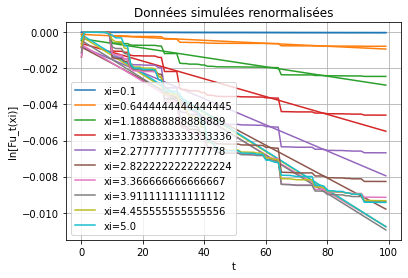

pente : -2.6325563063183747e-07
pente : -9.959131371888766e-06
pente : -2.78265420630381e-05
pente : -4.952566471934376e-05
pente : -7.215385402355756e-05
pente : -9.050487110216834e-05
pente : -0.00010349466226415704
pente : -0.00010555609975096307
pente : -0.00010333362283867046
pente : -0.00010240403746214369


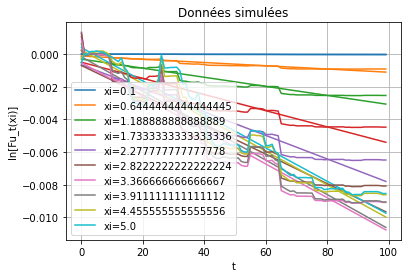

In [10]:
draw_log_log(wt_sim_norm,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,n_renorm=5,titre="Données simulées renormalisées")
draw_log_log(wt_sim,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,n_renorm=5,titre="Données simulées")

$\to$ les formes et les pentes sont similaires !

pente : -0.00010760280475328053
pente : -0.0001335051632422624
pente : -0.00019610937663563585
pente : -0.00025667506877884703
pente : -0.00028270551085145723


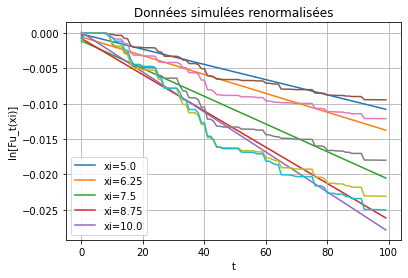

pente : -0.00010240403746214369
pente : -0.00013130962976932572
pente : -0.00022227087963207987
pente : -0.00033234923302045147
pente : -0.0003739253352974362


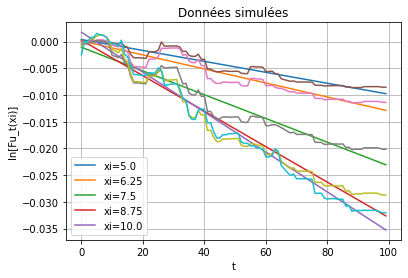

In [11]:
draw_log_log(wt_sim_norm,ximin=5,ximax=10,nbreaks_xi=5,tmax=100,n_renorm=5,titre="Données simulées renormalisées")
draw_log_log(wt_sim,ximin=5,ximax=10,nbreaks_xi=5,tmax=100,n_renorm=5,titre="Données simulées")

$\to$ la similarité est moins bonne quand $\xi$ augmente.

pente : -0.00028270551085145723
pente : -0.0003559258353647904
pente : -0.00044318880551215693
pente : -0.0004955518239461304
pente : -0.0004647308019782093


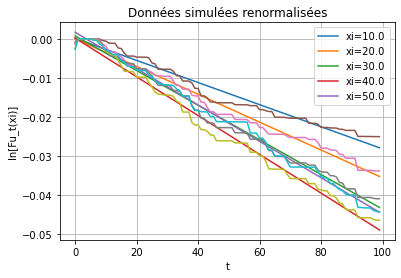

pente : -0.0003739253352974362
pente : -0.0003379298054723622
pente : -0.0030697979660868017
pente : -0.00344495243779158
pente : -0.0009232364494378455


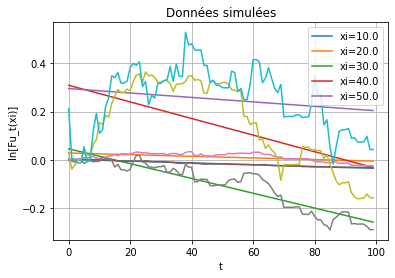

In [12]:
draw_log_log(wt_sim_norm,ximin=10,ximax=50,nbreaks_xi=5,tmax=100,n_renorm=5,titre="Données simulées renormalisées")
draw_log_log(wt_sim,ximin=10,ximax=50,nbreaks_xi=5,tmax=100,n_renorm=5,titre="Données simulées")

$\to$ les données non-renormalisées ne sont pas des droites : pourquoi ?

$\to$ les pentes n'ont plus de sens.

## Travail sur l'estimation de $\Im(a_{\xi})$

pente : 7.847239712905714e-06
pente : 4.900125499346132e-05
pente : 8.376658756839496e-05
pente : 0.00010870965671242957
pente : 0.00012330570177494928
pente : 0.00013004268289373643
pente : 0.00013352284712011504
pente : 0.00013884419910796116
pente : 0.0001498509606387355
pente : 0.0001678916120032064


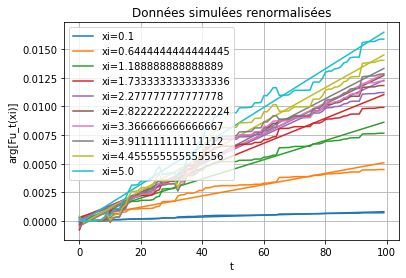

pente : 1.0084853847958595e-05
pente : 6.189665043681603e-05
pente : 0.00010434936042162653
pente : 0.00013780619723790583
pente : 0.00015983987486217527
pente : 0.00017294216127619524
pente : 0.00017844129580744068
pente : 0.0001820918039054554
pente : 0.00019299533073328497
pente : 0.000209410548417881


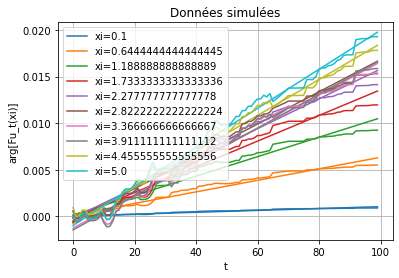

In [23]:
draw_log_arg(wt_sim_norm,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,n_renorm=5,titre="Données simulées renormalisées")
draw_log_arg(wt_sim,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=100,n_renorm=5,titre="Données simulées")

$\to$ correspondance potable des pentes

pente : 0.00022607683184174313
pente : 0.00022068595324071388
pente : 0.0001894152566900979
pente : 0.00017370498936353893
pente : 0.00025480420685981386


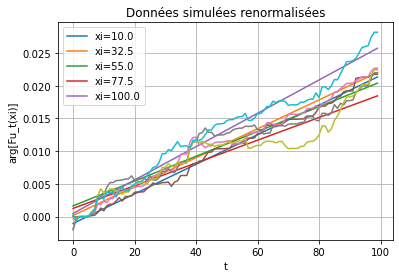

pente : 0.0001919861078725754
pente : 0.00777118901088362
pente : -0.0005897931511096261
pente : -0.000839746267019047
pente : 0.00037666301110385125


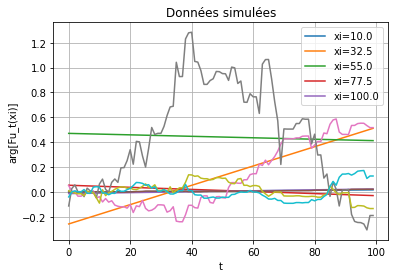

In [19]:
draw_log_arg(wt_sim_norm,ximin=10,ximax=100,nbreaks_xi=5,tmax=100,n_renorm=5,titre="Données simulées renormalisées")
draw_log_arg(wt_sim,ximin=10,ximax=100,nbreaks_xi=5,tmax=100,n_renorm=5,titre="Données simulées")

$\to$ pentes toujours pas potables pour les grandes valeurs de $\xi$

# Conclusion

Si on ne considère que les petites valeurs de $\xi$: la correspondance entre les données normalisées et les données non normalisées est très bonne (en principe, les pentes devraient être identiques).

Si on considère les grandes valeurs de $\xi$: on n'obtient plus de droite pour les données non normalisées. C'est mystérieux: erreur dans les calculs ? erreur dans le code ? erreur d'approximation ?

On obtient, tout de même, de belles droites pour les données normalisées. Cependant, on ne peut pas normaliser les données réelles car l'erreur devient trop grande.